# Braille detection with CNN
### Justine Diliberto, Anna Nikiforovskaja, Cindy Pereira

In this script we create, train and evaluate an image classifier based on convolutional networks.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset, DataLoader
import fnmatch
from skimage import io, transform
import torchvision
import pandas as pd

# Define the device and data repository
device = 'cpu'
data_dir = 'dataset/'

# Data management

We read data, split it onto train, val and test and create data loaders with preprocessing.

In [2]:
# We start by creating a class object for representing our image data
# This is a subclass of torch.utils.data.dataset.Dataset that will serve as input to the DataLoader

class ImageDataset(Dataset):

    def __init__(self, image_dir, transform=None):
        """Initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_files = sorted(self._find_files(image_dir))
        # Get the first character in each filename: corresponds to the letter of the file
        # ex: dataset/a1.JPG0dim.jpg -> get the "a"
        self.classes = [filename.split("/")[-1][0] for filename in self.image_files]
        # Create a dictionary associating a number to each letter
        self.let2num = {a: i for i, a in enumerate(sorted(list(set(self.classes))))}
        # Create the reverted dictionary with number as key
        self.num2let = {i: a for a, i in self.let2num.items()}
        self.transform = transform
        
    def letter_to_number(self, let):
        """Get the number associated to a letter"""
        return self.let2num[let]
    
    def number_to_letter(self, num):
        """Get the letter associated to a number"""
        return self.num2let[num]
    

    def __len__(self):
        """Get the size of the dataset."""
        return len(self.image_files)

    def __getitem__(self, index):
        """Here we return a data sample for a given index."""
        filename = self.image_files[index]
        x = io.imread(filename)
        
        if self.transform:
            x = self.transform(x)
        return x, self.classes[index]

    def _find_files(self, directory, pattern='*.jpg'):
        """Recursively finds all files matching the pattern."""
        files = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                files.append(os.path.join(root, filename))
        return files


In [3]:
# Create the transform to apply on the data
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(
                                                      mean=(0.5, 0.5, 0.5), 
                                                      std=(0.3,0.3,0.3))])

In [4]:
# Create the dataset
dataset = ImageDataset(image_dir=data_dir, transform=data_transforms)

Here we check that our Dataset class and functions work fine.

In [5]:
len(set(dataset.classes))

26

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


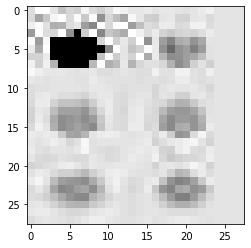

In [6]:
plt.imshow(dataset[0][0].numpy().transpose(1, 2, 0))

In [7]:
dataset[0][0].size()

torch.Size([3, 28, 28])

In [8]:
dataset.letter_to_number(dataset[0][1])

0

In [9]:
dataset.number_to_letter(0)

'a'

In [10]:
# Get the lengths of train (80%), validation (10%) and test (10%) sets
dataset_ln = len(dataset)
train_ln, val_ln, test_ln = int(dataset_ln * 0.8), int(dataset_ln * 0.1), int(dataset_ln * 0.1)

In [11]:
# Split the data into train, validation and test sets
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_ln, val_ln, test_ln], generator=torch.Generator().manual_seed(42))

In [12]:
len(val_data)

156

In [13]:
val_data[1]

(tensor([[[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          ...,
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536],
          [1.6536, 1.6536, 1.6536,  ..., 1.6405, 1.6405, 1.6536]],
 
         [[1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ..., 1.6013, 1.6275, 1.6536],
          [1.6667, 1.6667, 1.6536,  ...,

In [14]:
def collate_fn(data):
    """Associate images with labels"""
    images, labels = zip(*data)
    # Get the number corresponding to each label
    labels = [dataset.letter_to_number(label) for label in labels]
    return torch.stack(images).float(), torch.tensor(labels).long()


In [15]:
# Load data using a batch size of 8
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size, collate_fn=collate_fn)
val_dataloader = DataLoader(val_data, batch_size=batch_size, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn)

# Useful functions for training, validation and testing

In [16]:
def train_model(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, 
                device='cpu', verbose=True, model_name='simple', optim='SGD', cells=False):
    """Train the model"""

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    if optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    last_best_acc = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            #print(labels)
            #print(images.size(), labels.size(), labels)
            images = images.to(device)
            # cells is True if we use the 3rd model
            if cells:
                # In this case, labels are bits where 1 corresponds to a black dot in Braille
                new_labels = torch.zeros((len(labels), 6))
                for i, l in enumerate(labels):
                    new_labels[i] = torch.tensor(list(map(int, braille_map[dataset.number_to_letter(l.item())]))).float()
                labels = new_labels
            else:
                labels = labels.to(device)
            # Predict ys
            y_pred = model(images)
            # Apply loss function on predictions
            loss = loss_fn(y_pred, labels)
            
            # Compute the gradient
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Set the gradients to 0
            optimizer.zero_grad()
            # Update the loss
            loss_current_epoch += loss.item()
        
        # Compute the accuracy
        cur_acc = eval_model(model, valid_dataloader)
        # Save the parameters it's the new best accuracy 
        if cur_acc > last_best_acc:
            last_best_acc = cur_acc
            torch.save(model.state_dict(), f'models/model_{model_name}_best.pt')
            print("\nNew best accuracy! ", last_best_acc)
            
        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('\rEpoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch), end='')
        
    return model, loss_all_epochs

In [17]:
def eval_model(model, eval_dataloader, device='cpu'):
    """Evaluate the model"""
    
    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # Initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [18]:
# Create a dataframe to store the results
all_results = {"Model":[], "Loss":[], "Optimizer":[], "lr":[], "Accuracy":[]}

# First model

In [19]:
# Define a CNN classifier module.

class CNNSimpleClassif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        """Models a simple classifier"""
        super(CNNSimpleClassif, self).__init__()
        
        # Create two sequential layers with convolution, ReLU, BatchNorm and Max Pooling
        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        # Create a linear layer
        self.res = nn.Linear(size_vec, num_classes)
        

    def forward(self, x):
        """Move from the input layers to the output layer"""
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(x)
        return out

## Experiments

In [20]:
# Set the parameters
num_channels1 = 16
num_channels2 = 32
num_classes = 26
# Create the model following the simple classifier
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)


New best accuracy!  44.87179487179487
Epoch [1/20], Loss: 424.5679
New best accuracy!  58.97435897435897
Epoch [2/20], Loss: 260.0883
New best accuracy!  63.46153846153846
Epoch [3/20], Loss: 201.2330
New best accuracy!  66.66666666666667
Epoch [4/20], Loss: 167.8934
New best accuracy!  67.94871794871794
Epoch [5/20], Loss: 144.9518
New best accuracy!  72.43589743589743
Epoch [9/20], Loss: 86.36466
New best accuracy!  75.0
Epoch [11/20], Loss: 66.9110
New best accuracy!  76.28205128205128
Epoch [12/20], Loss: 60.0730
New best accuracy!  78.2051282051282
Epoch [14/20], Loss: 47.9569
New best accuracy!  78.84615384615384
Epoch [15/20], Loss: 42.4421
New best accuracy!  79.48717948717949
Epoch [16/20], Loss: 38.0731
New best accuracy!  80.12820512820512
Epoch [17/20], Loss: 33.1960
New best accuracy!  80.76923076923077
Epoch [19/20], Loss: 26.4306
New best accuracy!  81.41025641025641
Epoch [20/20], Loss: 23.8893

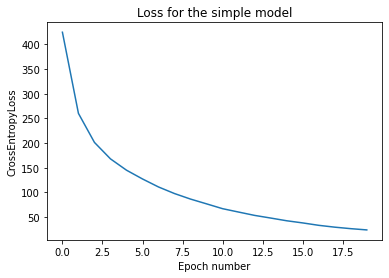

In [21]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_simple.pt')
plt.plot(loss_total)

# Plot the results and save the figure
plt.title("Loss for the simple model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_loss.png")
plt.show() 

In [22]:
# Create the model using simple classifier
model = CNNSimpleClassif(num_channels1, num_channels2, num_classes)
# Load the model
model.load_state_dict(torch.load('models/model_simple_best.pt'))
# Compute the accuracy
res = eval_model(model, test_dataloader, device='cpu')
print(res)

83.33333333333333


In [23]:
# Fill dataframe with the results of this model
all_results["Model"].append("simple")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optimizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

# Second model

In [24]:
# Define a CNN classifier module.

class CNNSimple6Cells(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=26):
        """Models a classifier using the 6 dots"""
        super(CNNSimple6Cells, self).__init__()
        
        # Create two sequential layers with convolution, ReLU, BatchNorm and Max Pooling
        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        # Create a sequential layer with linear and ReLU 
        self.lin6 = nn.Sequential(nn.Linear(size_vec, 6), nn.ReLU())
        # Create a sequential layer with linear, ReLU and another linear
        self.res = nn.Sequential(nn.Linear(6, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, num_classes))
        
    def forward(self, x):
        """Move from the input layers to the output layer"""
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.res(self.lin6(x))
        return out

In [ ]:
# Set the parameters
num_channels1 = 16
num_channels2 = 32
num_classes = 26
# Create the model
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)

# Optimizer
num_epochs = 40
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.003

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells", optim='Adam')

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_simple_6_cells.pt')

# Plot the results and save the figure
plt.plot(loss_total)
plt.title("Loss for the 6cells model")
plt.xlabel("Epoch number")
plt.ylabel("CrossEntropyLoss")
plt.savefig("plots/model_simple_6cells_loss.png") 
plt.show()


New best accuracy!  21.794871794871796
Epoch [1/40], Loss: 449.3016
New best accuracy!  33.333333333333336
Epoch [2/40], Loss: 340.4751
New best accuracy!  49.35897435897436
Epoch [3/40], Loss: 271.5713
New best accuracy!  56.41025641025641
Epoch [4/40], Loss: 220.4931
New best accuracy!  57.05128205128205
Epoch [5/40], Loss: 191.6558
New best accuracy!  62.82051282051282
Epoch [7/40], Loss: 158.9903
New best accuracy!  65.38461538461539
Epoch [8/40], Loss: 142.7732
New best accuracy!  68.58974358974359
Epoch [9/40], Loss: 125.4904
New best accuracy!  71.15384615384616
Epoch [10/40], Loss: 113.6389
New best accuracy!  74.35897435897436
Epoch [13/40], Loss: 91.80490
New best accuracy!  77.56410256410257
Epoch [19/40], Loss: 52.8179
New best accuracy!  78.84615384615384
Epoch [20/40], Loss: 59.3241
New best accuracy!  80.12820512820512
Epoch [26/40], Loss: 39.8912

In [ ]:
# Create the 6 cells model
model = CNNSimple6Cells(num_channels1, num_channels2, num_classes)
# Load the parameters
model.load_state_dict(torch.load('models/model_6cells_best.pt'))
# Compute the accuracy
res = eval_model(model, test_dataloader, device='cpu')
print(res)

In [ ]:
# Fill dataframe with the results of this model
all_results["Model"].append("6cells")
all_results["Loss"].append("CrossEntropyLoss")
all_results["Optimizer"].append("Adam")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

# Third model

In [ ]:
# Create a map between letters and braille alphabet
# 1 is a black dot
# 0 is a white dot 
braille_map = {"a":"100000", "b":"110000", "c":"100100", "d":"100110", "e":"100010",
               "f":"110100", "g":"110110", "h":"110010", "i":"010100", "j":"101000",
               "k":"111000", "l":"101100", "m":"101110", "n":"101110", "o":"101010",
               "p":"111100", "q":"111110", "r":"111010", "s":"011100", "t":"011110",
               "u":"101001", "v":"111001", "w":"010111", "x":"101101", "y":"101111",
               "z":"101011"}

In [ ]:
# Create the reverted map to go from dots to letters
braille_map_rev = {v:k for k, v in braille_map.items()}

In [ ]:
# Define a CNN classifier module.

class CNNSimple6CellsMap(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32):
        """Models a classifier using the bit strings"""
        super(CNNSimple6CellsMap, self).__init__()
        
        # Create two sequential layers with convolution, ReLU, BatchNorm and Max Pooling
        self.l1 = nn.Sequential(nn.Conv2d(3, num_channels1, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(16),
                           nn.MaxPool2d(kernel_size=2))
        self.l2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(32),
                           nn.MaxPool2d(kernel_size=2))
        
        size_vec = 1568
        
        # Create linear and sigmoid functions
        self.res = nn.Linear(size_vec, 6)
        self.finact = nn.Sigmoid()
        
    def forward(self, x):
        """Move from the input layers to the output layer"""
        x = self.l2(self.l1(x))
        x = x.reshape(x.shape[0], -1)
        out = self.finact(self.res(x))
        if self.training:
            return out
        else:
            res = []
            for t in out:
                key = "".join(map(lambda a: str(a.item()), torch.round(t).long()))
                if key not in braille_map_rev:
                    res.append(0)
                    continue
                res.append(dataset.letter_to_number(braille_map_rev[key]))
            res = nn.functional.one_hot(torch.tensor(res), num_classes=26)
            return res

## Experiments

In [ ]:
# Set the parameters
num_channels1 = 16
num_channels2 = 32
num_classes = 26
# Create the model
model = CNNSimple6CellsMap(num_channels1, num_channels2)

# Optimizer
num_epochs = 40
loss_fn = nn.BCELoss()
learning_rate = 0.01

# Training
model, loss_total = train_model(model, train_dataloader, val_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True, model_name="6cells_map", optim='SGD', cells=True)

# Save the model and display the loss over epochs
torch.save(model.state_dict(), 'models/model_6_cells_map.pt')

# Plot the results and save the figure
plt.title("Loss for the 6cells + map model")
plt.xlabel("Epoch number")
plt.ylabel("BCELoss")

plt.plot(loss_total)
plt.savefig("plots/model_simple_6cells_map_loss.png") 
plt.show()

In [ ]:
# Create the bit model
model = CNNSimple6CellsMap(num_channels1, num_channels2)
# Load the parameters
model.load_state_dict(torch.load('models/model_6cells_map_best.pt'))
# Compute the accuracy
res = eval_model(model, test_dataloader, device='cpu')
print(res)

In [ ]:
# Fill dataframe with the results of this model
all_results["Model"].append("6cells_map")
all_results["Loss"].append("BCELoss")
all_results["Optimizer"].append("SGD")
all_results["lr"].append(learning_rate)
all_results["Accuracy"].append(res)

In [ ]:
df_results = pd.DataFrame(all_results)

In [ ]:
df_results.to_csv("evaluation_results.csv")

In [ ]:
df_results

In [ ]:
pd.read_csv("evaluation_results.csv", index_col=0)